In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
sys.path.extend(["..", "../backbone"])
import torchvision.transforms as transforms
from transform import Transform
from data import RetinaDataset
from metric import Metric
import cv2
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
torch.cuda.empty_cache()

device = torch.device("cuda:0")
model = torch.load('models/dn1.pth')
model.to(device)

CTranEncoder(
  (backbone): DenseNet201(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mom

In [2]:
df = pd.read_csv('../../../data/GT-main/set1/all.csv')
image_names = ["2", "18"]
idx = df[df['ID'].isin(image_names)].index.tolist()
print(idx)

[1733]


In [3]:
filename1 = './gradcam/all-dn1.png'

data_dir = '../../../data/GT-main'
batch_size = 16
image_size = 384
num_labels = 21
num_workers = 4
thresholds = [0.5] * num_labels
phase = 'all'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
threshold = [0.65, 0.7, 0.49, 0.43, 0.66, 0.78, 0.26, 0.21, 0.38, 0.82, 0.64, 0.9, 0.38, 0.59, 0.86, 0.31, 0.51, 0.69, 0.91, 0.23, 0.37]
class_names = ["DR","NORMAL","MH","ODC","TSLN","ARMD","DN","MYA","BRVO","ODP","CRVO","CNV","RS","ODE","LS","CSR","HTR","ASR","CRS","OTHER","RB"]

384
../../../data/GT-main/./set1/all.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


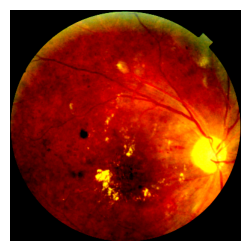

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
torch.Size([1, 21]) torch.Size([1, 384, 384, 3])


In [4]:
transform = Transform(size=image_size, phase=phase)
label_list = []
image_list = []
dataset = RetinaDataset(data_dir=data_dir, split=phase, transform=transform)
for i in idx:
    image = dataset[i][0]
    label = dataset[i][1]
    image_list.append(image.permute(1,2,0).unsqueeze(0))
    label_list.append(label.unsqueeze(0))
    plt.figure(figsize=(1, 1))
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()
    print(label)

images = torch.cat(image_list, dim=0)
labels = torch.cat(label_list, dim=0)
true_labels = labels.detach().cpu().numpy().astype(np.int32)
print(true_labels)
print(labels.shape, images.shape)

In [5]:
# print(model.backbone)

DenseNet201(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [6]:
def predict(x):
    tmp = torch.tensor(x).to(device)
    tmp = tmp.permute(0,3,1,2)
    return torch.sigmoid(model(tmp))

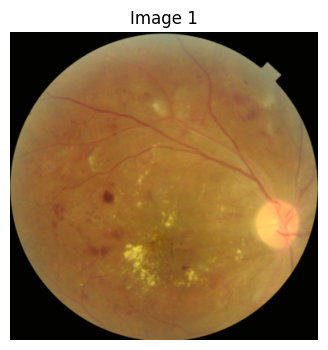

In [7]:
# Define the inverse transformation function
inv_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    transforms.Normalize(mean=(-1 * np.array(mean) / np.array(std)).tolist(),std=(1 / np.array(std)).tolist(),),
    transforms.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

# Apply the inverse transformation to the transformed image tensor
original_images = inv_transform(images)
original_images = original_images.numpy()

# Plot the original images
plt.figure(figsize=(1, 1))
for i in range(original_images.shape[0]):
    plt.subplot(1, original_images.shape[0], i + 1)
    plt.imshow(original_images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')
plt.show()

In [8]:
print(images[i].unsqueeze(0).shape)

torch.Size([1, 384, 384, 3])


In [9]:
target_layer = model.backbone.features.denseblock4.denselayer32.conv2
gradients = None
activations = []

def get_activations(module, input, output):
    global activations
    activations.append(output)

def activations_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output  # or grad_output, depending on what you need

target_layer.register_backward_hook(activations_hook)
target_layer.register_forward_hook(get_activations)

In [10]:
model.eval()
output = predict(images)
pred = output[:,0]
print(output.shape, output[0].shape, output[0,0])

thresholds = [0.5]*num_labels
outputs = output.detach().cpu().numpy()
outputs_thresholded = (outputs > thresholds).astype(np.int32)
print(outputs_thresholded)

/tmp/ipykernel_2431530/245938574.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.tensor(x).to(device)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([1, 21]) torch.Size([21]) tensor(0.9922, device='cuda:0', grad_fn=<SelectBackward0>)
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [11]:
pred.backward()


In [12]:
grads = gradients
print(grads[0].shape)

torch.Size([1, 32, 12, 12])


In [13]:
print(activations[0].shape)

torch.Size([1, 32, 12, 12])


In [18]:
activs = activations[0].detach()
pooled_grads = torch.mean(grads[0], dim=[0, 2, 3])
print(activs.shape, activs.type, pooled_grads.shape, pooled_grads.type)

torch.Size([1, 32, 12, 12]) <built-in method type of Tensor object at 0x7009c42d88b0> torch.Size([32]) <built-in method type of Tensor object at 0x7009c42a0360>


In [19]:
# weight the channels by corresponding gradients
for i in range(pooled_gradients.size(0)):
    activs[:, i, :, :] *= pooled_gradients[i]

In [29]:
# average the channels of the activations
heatmap = torch.mean(activs, dim=1).squeeze().detach().cpu()

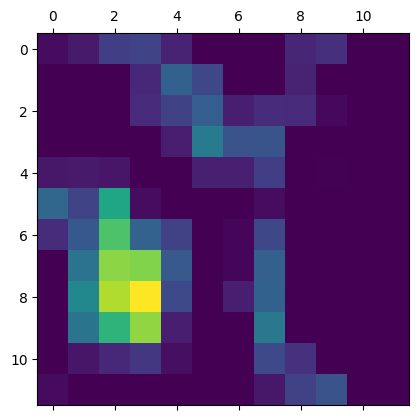

In [30]:
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [32]:
print(heatmap.shape, heatmap.device)
heatmap = heatmap.numpy()

torch.Size([12, 12]) cpu


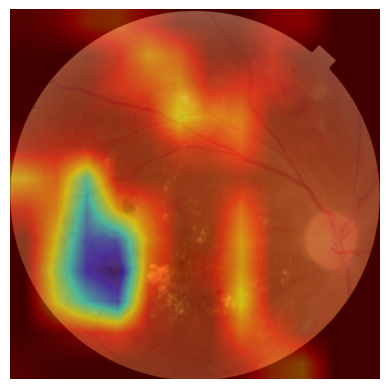

In [33]:
image_path = '../../../data/images/2.png'  
image = cv2.imread(image_path)

# Convert the image from BGR to RGB (since OpenCV reads images in BGR format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the heatmap to match the image dimensions
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Normalize the heatmap to the range [0, 1]
heatmap_resized = np.float32(heatmap_resized)
heatmap_resized = heatmap_resized - np.min(heatmap_resized)
heatmap_resized = heatmap_resized / np.max(heatmap_resized)

# Apply a color map to the heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = np.float32(heatmap_colored) / 255

# Overlay the heatmap on the image
overlayed_image = heatmap_colored + np.float32(image) / 255
overlayed_image = overlayed_image / np.max(overlayed_image)

# Display the resulting image
plt.imshow(overlayed_image)
plt.axis('off')  # Hide axis
plt.show()